<a href="https://colab.research.google.com/github/SyaidFarhan/Project_Kuliah_Syaid/blob/main/Business_Intelegence_(Analisis_Big_Data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mlxtend --quiet

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving auction.csv to auction.csv


In [ ]:
import pandas as pd
df = pd.read_csv('auction.csv')
df.info()
df.head(10000)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10681 entries, 0 to 10680
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   auctionid     10681 non-null  int64  
 1   bid           10681 non-null  float64
 2   bidtime       10681 non-null  float64
 3   bidder        10665 non-null  object 
 4   bidderrate    10670 non-null  float64
 5   openbid       10681 non-null  float64
 6   price         10681 non-null  float64
 7   item          10681 non-null  object 
 8   auction_type  10681 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 751.1+ KB


,auctionid,bid,bidtime,bidder,bidderrate,openbid,price,item,auction_type
0,1638893549,175.00,2.230949,schadenfreud,0.0,99.0,177.5,Cartier wristwatch,3 day auction
1,1638893549,100.00,2.600116,chuik,0.0,99.0,177.5,Cartier wristwatch,3 day auction
2,1638893549,120.00,2.600810,kiwisstuff,2.0,99.0,177.5,Cartier wristwatch,3 day auction
3,1638893549,150.00,2.601076,kiwisstuff,2.0,99.0,177.5,Cartier wristwatch,3 day auction
4,1638893549,177.50,2.909826,eli.flint@flightsafety.co,4.0,99.0,177.5,Cartier wristwatch,3 day auction
...,...,...,...,...,...,...,...,...,...
9995,8213037774,18.11,0.420509,fisherman-clint,6.0,1.0,127.5,Xbox game console,7 day auction
9996,8213037774,60.00,1.622824,slobman69,19.0,1.0,127.5,Xbox game console,7 day auction
9997,8213037774,72.00,2.859942,nicoleclover,6.0,1.0,127.5,Xbox game console,7 day auction
9998,8213037774,75.00,3.943970,skcardina,1.0,1.0,127.5,Xbox game console,7 day auction


In [ ]:
import pandas as pd
import numpy as np

# 1. Baca Data
df = pd.read_csv('/content/auction.csv')

# 2. Cek info umum
print("Ukuran dataset:", df.shape)
print("\nInfo kolom:")
df.info()

# 3. Tangani missing values
print("\nMissing values per kolom:")
print(df.isnull().sum())

# Hapus baris dengan missing value (bisa juga isi jika perlu)
df_clean = df.dropna()

# 4. Hapus duplikasi (jika ada)
print("\nJumlah duplikat:", df_clean.duplicated().sum())
df_clean = df_clean.drop_duplicates()

# 5. Standardisasi teks pada kolom 'item' dan 'auction_type'
df_clean['item'] = df_clean['item'].str.lower().str.strip()
df_clean['auction_type'] = df_clean['auction_type'].str.lower().str.strip()

# 6. Feature Engineering

# Hitung total jumlah bid per lelang (auctionid)
bid_count = df_clean.groupby('auctionid').size().reset_index(name='jumlah_bid')

# Hitung rentang bidtime per auction (durasi penawaran)
bid_range = df_clean.groupby('auctionid')['bidtime'].agg(['min', 'max'])
bid_range['durasi_bid'] = bid_range['max'] - bid_range['min']
bid_range = bid_range.reset_index()[['auctionid', 'durasi_bid']]

# Gabungkan kembali ke dataframe utama (hapus duplikat auctionid untuk ringkasan per lelang)
auction_summary = df_clean.drop_duplicates(subset='auctionid')[['auctionid', 'openbid', 'price', 'item', 'auction_type']]
auction_summary = auction_summary.merge(bid_count, on='auctionid')
auction_summary = auction_summary.merge(bid_range, on='auctionid')

# Hitung selisih harga akhir dengan open bid
auction_summary['selisih_bid'] = auction_summary['price'] - auction_summary['openbid']


Ukuran dataset: (10681, 9)

Info kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10681 entries, 0 to 10680
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   auctionid     10681 non-null  int64  
 1   bid           10681 non-null  float64
 2   bidtime       10681 non-null  float64
 3   bidder        10665 non-null  object 
 4   bidderrate    10670 non-null  float64
 5   openbid       10681 non-null  float64
 6   price         10681 non-null  float64
 7   item          10681 non-null  object 
 8   auction_type  10681 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 751.1+ KB

Missing values per kolom:
auctionid        0
bid              0
bidtime          0
bidder          16
bidderrate      11
openbid          0
price            0
item             0
auction_type     0
dtype: int64

Jumlah duplikat: 0


# Bagian Baru

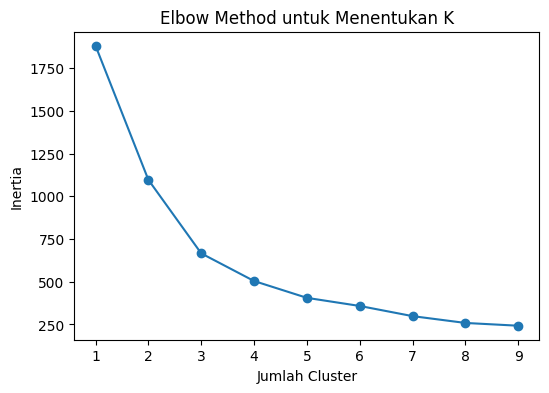

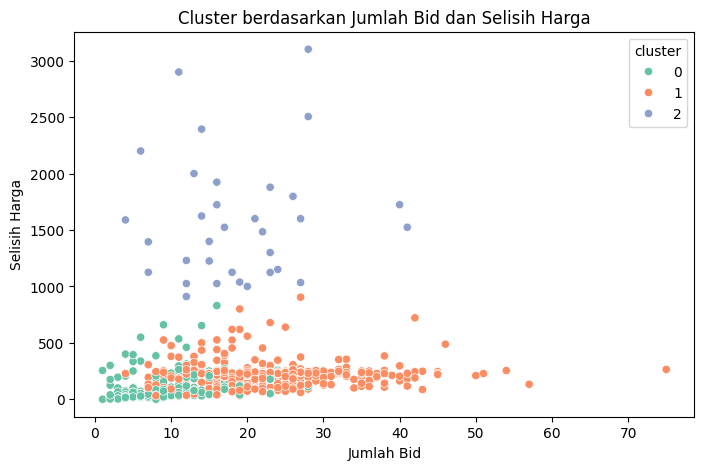

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Ambil fitur numerik yang akan digunakan untuk clustering
features = auction_summary[['jumlah_bid', 'durasi_bid', 'selisih_bid']]

# 2. Standardisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 3. Tentukan jumlah cluster (uji dengan elbow method)
inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# 4. Plot elbow curve
plt.figure(figsize=(6,4))
plt.plot(range(1,10), inertia, marker='o')
plt.title('Elbow Method untuk Menentukan K')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')
plt.show()

# Misalnya kita pilih 3 cluster
kmeans = KMeans(n_clusters=3, random_state=42)
auction_summary['cluster'] = kmeans.fit_predict(X_scaled)

# Visualisasi scatter plot
plt.figure(figsize=(8,5))
sns.scatterplot(data=auction_summary, x='jumlah_bid', y='selisih_bid', hue='cluster', palette='Set2')
plt.title('Cluster berdasarkan Jumlah Bid dan Selisih Harga')
plt.xlabel('Jumlah Bid')
plt.ylabel('Selisih Harga')
plt.show()



In [ ]:
# Statistik rata-rata per cluster
cluster_summary = auction_summary.groupby('cluster')[['jumlah_bid', 'selisih_bid', 'durasi_bid']].mean().round(2)
print(cluster_summary)


         jumlah_bid  selisih_bid  durasi_bid
cluster                                     
0              8.42        89.67        1.53
1             23.35       216.46        5.81
2             18.91      1588.20        5.59


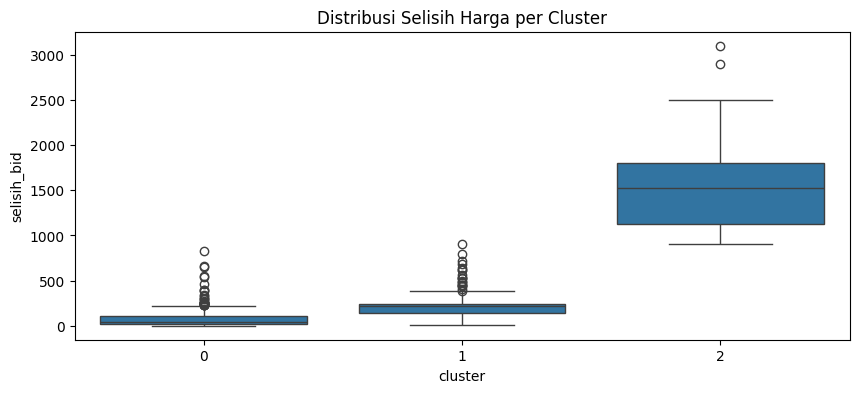

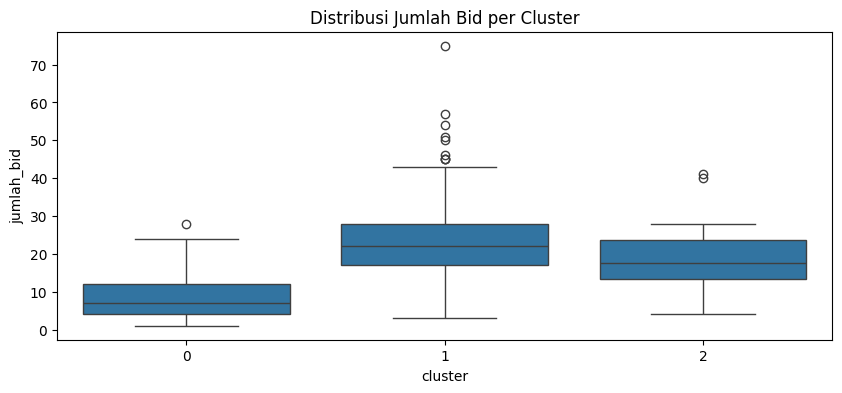

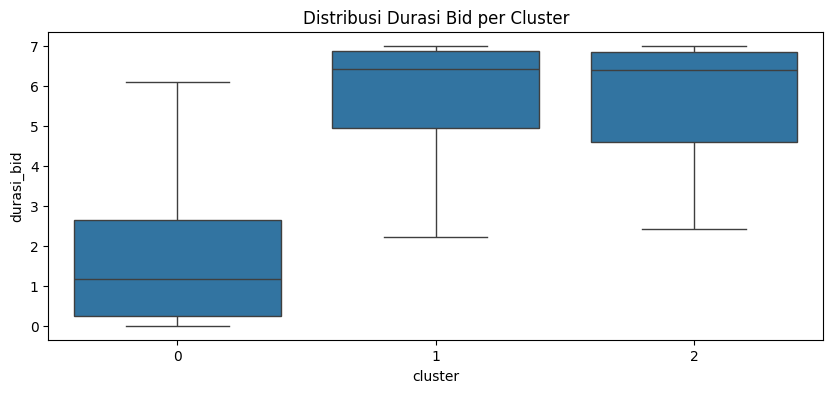

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sns.boxplot(x='cluster', y='selisih_bid', data=auction_summary)
plt.title('Distribusi Selisih Harga per Cluster')
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(x='cluster', y='jumlah_bid', data=auction_summary)
plt.title('Distribusi Jumlah Bid per Cluster')
plt.show()

plt.figure(figsize=(10,4))
sns.boxplot(x='cluster', y='durasi_bid', data=auction_summary)
plt.title('Distribusi Durasi Bid per Cluster')
plt.show()



In [ ]:
cluster_summary = auction_summary.groupby('cluster')[['jumlah_bid', 'durasi_bid', 'selisih_bid']].agg(['mean', 'median', 'count']).round(2)
cluster_summary


jumlah_bid              durasi_bid              selisih_bid           \
              mean median count       mean median count        mean   median   
cluster                                                                        
0             8.42    7.0   257       1.53   1.16   257       89.67    45.00   
1            23.35   22.0   336       5.81   6.43   336      216.46   219.76   
2            18.91   17.5    34       5.59   6.39    34     1588.20  1524.00   

               
        count  
cluster        
0         257  
1         336  
2          34

### 🔍 Insight Deskriptif Clustering

- **Cluster 0** → Produk dengan sedikit bid (avg 8), durasi pendek (~1.5), dan selisih harga rendah (~89) → kemungkinan produk tidak diminati atau cepat dilelang dengan sedikit persaingan.
- **Cluster 1** → Produk dengan bid terbanyak (avg 23), durasi lama (~5.8), dan selisih harga menengah (~216) → produk kompetitif dan menarik minat pembeli.
- **Cluster 2** → Produk dengan selisih harga **sangat tinggi** (avg 1588), meskipun bid dan durasi tidak setinggi Cluster 1 → kemungkinan barang premium atau terjadi lonjakan harga (anomali).

### ⚠️ Diagnostic & Anomali

- **Cluster 2** patut dianalisis lebih lanjut karena selisih harga sangat tinggi → apakah ini produk eksklusif, atau ada praktik menaikkan harga secara tidak wajar?
- **Cluster 0** mungkin berisi produk-produk yang perlu ditinjau ulang atau dipromosikan lebih agresif karena kurang diminati.


In [ ]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Baca Data
df = pd.read_csv('auction.csv')

# 2. Lakukan preprocessing data
print("Ukuran dataset awal:", df.shape)
print("\nInformasi kolom:")
df.info()

print("\nMissing values per kolom:")
print(df.isnull().sum())

# Tangani missing values
df_clean = df.dropna()
print("\nUkuran dataset setelah menghapus missing values:", df_clean.shape)

# Standardisasi teks pada kolom kategorikal
df_clean['item'] = df_clean['item'].str.lower().str.strip()
df_clean['auction_type'] = df_clean['auction_type'].str.lower().str.strip()

# 3. Feature Engineering - Menciptakan kategori-kategori untuk association rules
print("\nMelakukan feature engineering...")

# Kategorisasi bid berdasarkan range harga
def categorize_bid(bid_value):
    if bid_value <= 50:
        return 'bid_low'
    elif 50 < bid_value <= 200:
        return 'bid_medium'
    else:
        return 'bid_high'

# Kategorisasi harga akhir
def categorize_price(price):
    if price <= 100:
        return 'price_low'
    elif 100 < price <= 500:
        return 'price_medium'
    else:
        return 'price_high'

# Kategorisasi bidder berdasarkan rating
def categorize_rating(rating):
    if rating <= 5:
        return 'bidder_new'
    elif 5 < rating <= 20:
        return 'bidder_regular'
    else:
        return 'bidder_frequent'

# Kategorisasi durasi penawaran
def categorize_bidtime(time):
    if time <= 1:
        return 'time_short'
    elif 1 < time <= 4:
        return 'time_medium'
    else:
        return 'time_long'

# Ekstrak kategori item dari nama item (menggunakan kata pertama sebagai kategori)
df_clean['item_category'] = df_clean['item'].str.split().str[0]

# Buat semua kategori baru
df_clean['bid_category'] = df_clean['bid'].apply(categorize_bid)
df_clean['price_category'] = df_clean['price'].apply(categorize_price)
df_clean['bidder_category'] = df_clean['bidderrate'].apply(categorize_rating)

# Tambahkan informasi selisih harga dan persentase kenaikan
df_clean['price_increase'] = df_clean['price'] - df_clean['openbid']
df_clean['price_increase_pct'] = (df_clean['price_increase'] / df_clean['openbid']) * 100

# Kategorisasi persentase kenaikan harga
def categorize_increase(pct):
    if pct <= 20:
        return 'increase_low'
    elif 20 < pct <= 100:
        return 'increase_medium'
    else:
        return 'increase_high'

df_clean['increase_category'] = df_clean['price_increase_pct'].apply(categorize_increase)

# 4. Persiapkan data untuk association rule dengan PENDEKATAN BERBASIS KARAKTERISTIK LELANG
print("\nMenyiapkan data untuk association rule mining...")

# Untuk setiap auction_id, kita akan mendata karakteristiknya
auction_features = df_clean.groupby('auctionid').agg({
    'item_category': 'first',
    'auction_type': 'first',
    'openbid': 'first',
    'price': 'first',
    'price_category': 'first',
    'increase_category': 'first',
    'bidtime': ['min', 'max']
}).reset_index()

# Hitung durasi total bidding untuk tiap lelang
auction_features['bidding_duration'] = auction_features[('bidtime', 'max')] - auction_features[('bidtime', 'min')]
auction_features['duration_category'] = auction_features['bidding_duration'].apply(categorize_bidtime)



Ukuran dataset awal: (10681, 9)

Informasi kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10681 entries, 0 to 10680
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   auctionid     10681 non-null  int64  
 1   bid           10681 non-null  float64
 2   bidtime       10681 non-null  float64
 3   bidder        10665 non-null  object 
 4   bidderrate    10670 non-null  float64
 5   openbid       10681 non-null  float64
 6   price         10681 non-null  float64
 7   item          10681 non-null  object 
 8   auction_type  10681 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 751.1+ KB

Missing values per kolom:
auctionid        0
bid              0
bidtime          0
bidder          16
bidderrate      11
openbid          0
price            0
item             0
auction_type     0
dtype: int64

Ukuran dataset setelah menghapus missing values: (10654, 9)

Melakukan feature engineering...

<ipython-input-2-598e2e31a762>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['item'] = df_clean['item'].str.lower().str.strip()
<ipython-input-2-598e2e31a762>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['auction_type'] = df_clean['auction_type'].str.lower().str.strip()
<ipython-input-2-598e2e31a762>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
# Hitung durasi total bidding untuk tiap lelang
# Flatten the MultiIndex columns before adding new ones or merging
auction_features.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in auction_features.columns]

auction_features['bidding_duration'] = auction_features['bidtime_max'] - auction_features['bidtime_min']
auction_features['duration_category'] = auction_features['bidding_duration'].apply(categorize_bidtime)

# Now merge bid_counts
bid_counts = df_clean.groupby('auctionid').size().reset_index(name='bid_count')
auction_features = auction_features.merge(bid_counts, on='auctionid')

auction_features.head()

,auctionid,item_category_first,auction_type_first,openbid_first,price_first,price_category_first,increase_category_first,bidtime_min,bidtime_max,bidding_duration,duration_category,bid_count
0,1638843936,cartier,7 day auction,500.0,1625.0,price_high,increase_high,0.478368,6.893113,6.414745,time_long,7
1,1638844284,cartier,7 day auction,200.0,500.0,price_medium,increase_high,1.237419,1.252407,0.014988,time_short,2
2,1638844464,cartier,7 day auction,300.0,740.0,price_high,increase_high,1.811134,6.999745,5.188611,time_long,16
3,1638844729,cartier,7 day auction,225.0,320.0,price_medium,increase_medium,6.121782,6.999213,0.877431,time_short,11
4,1638893549,cartier,3 day auction,99.0,177.5,price_medium,increase_medium,2.230949,2.909826,0.678877,time_short,5



Menyiapkan data untuk association rule mining...
Columns after flattening and merging bid_counts:
Index(['auctionid', 'item_category_first', 'auction_type_first',
       'openbid_first', 'price_first', 'price_category_first',
       'increase_category_first', 'bidtime_min', 'bidtime_max',
       'bidding_duration', 'duration_category', 'bid_count'],
      dtype='object')
Columns after merging highest_bidders:
Index(['auctionid', 'item_category_first', 'auction_type_first',
       'openbid_first', 'price_first', 'price_category_first',
       'increase_category_first', 'bidtime_min', 'bidtime_max',
       'bidding_duration', 'duration_category', 'bid_count',
       'bid_count_category', 'bidder_category'],
      dtype='object')

Mempersiapkan dataframe biner untuk apriori...
Error: The following features for rules are missing from auction_features: ['item_category', 'auction_type', 'price_category', 'increase_category']
Proceeding with available features: ['duration_category', 'bid_cou

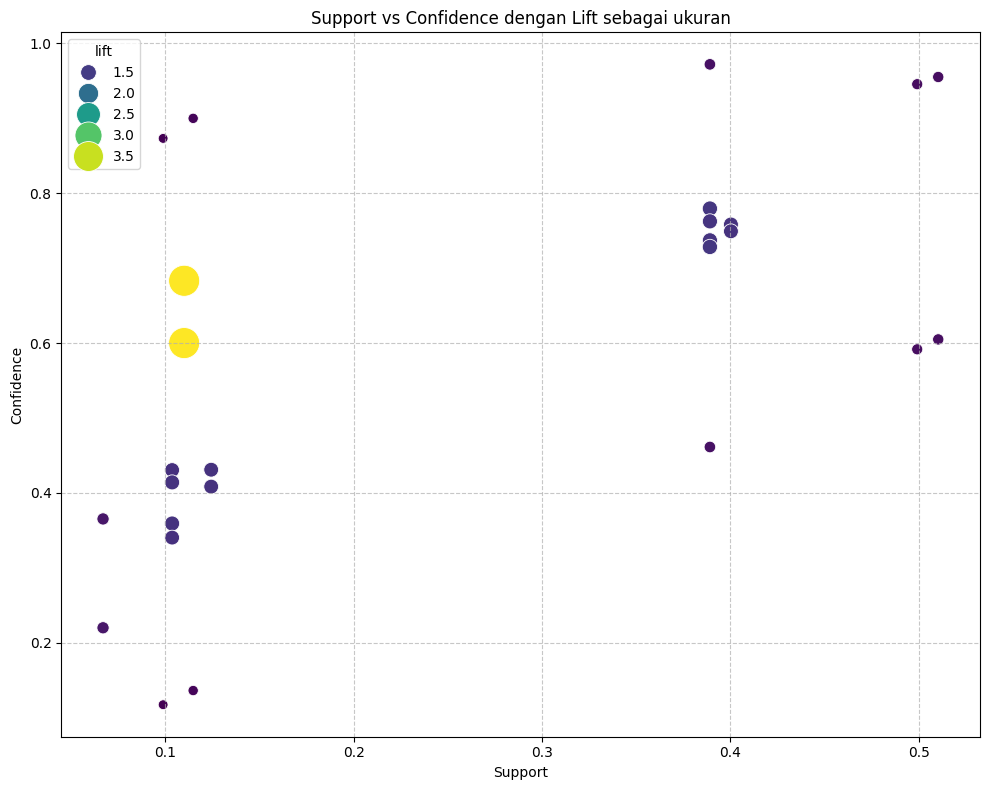


Analisis rules berdasarkan kategori item...
No item category rules found for visualization.

Analisis rules terkait peningkatan harga tinggi...
Top 5 rules yang terkait dengan peningkatan harga tinggi:
Tidak ditemukan rules terkait peningkatan harga tinggi.

Analisis rules terkait jumlah bid tinggi...
Top 5 rules yang terkait dengan jumlah bid tinggi:
- bidder: category: bidder: frequent, duration: category: time: long → Banyak bid (Lift: 1.46, Confidence: 0.78)
- duration: category: time: long → Banyak bid (Lift: 1.44, Confidence: 0.74)
- duration: category: time: long → Banyak bid (Lift: 1.42, Confidence: 0.76)
- bidder: category: bidder: frequent → Banyak bid (Lift: 1.15, Confidence: 0.46)
- bidder: category: bidder: frequent → Banyak bid (Lift: 1.13, Confidence: 0.60)

=== KESIMPULAN DAN INSIGHT ===

1. Karakteristik lelang yang saling berhubungan:
   - duration: category: time: short → bid: count: category: few: bids (Lift: 3.72, Confidence: 0.60)
   - bid: count: category: few: 

In [ ]:
# Assume df_clean is already available from previous steps

# 4. Persiapkan data untuk association rule dengan PENDEKATAN BERBASIS KARAKTERISTIK LELANG
print("\nMenyiapkan data untuk association rule mining...")

# --- Recreate auction_features from df_clean to ensure clean state ---
# For setiap auction_id, kita akan mendata karakteristiknya
auction_features = df_clean.groupby('auctionid').agg({
    'item_category': 'first',
    'auction_type': 'first',
    'openbid': 'first',
    'price': 'first',
    'price_category': 'first',
    'increase_category': 'first',
    'bidtime': ['min', 'max'] # This creates a MultiIndex column for bidtime
}).reset_index()

# Flatten the MultiIndex columns created by .agg() before adding new ones
# This needs to happen *after* the aggregation step
auction_features.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in auction_features.columns]

# Hitung durasi total bidding untuk tiap lelang using the flattened columns
auction_features['bidding_duration'] = auction_features['bidtime_max'] - auction_features['bidtime_min']
auction_features['duration_category'] = auction_features['bidding_duration'].apply(categorize_bidtime)

# Now merge bid_counts - This merge will now have a fresh auction_features
bid_counts = df_clean.groupby('auctionid').size().reset_index(name='bid_count')
# Ensure 'bid_count' doesn't exist in auction_features from previous runs
# (This is handled by recreating auction_features above, but good to be mindful)
if 'bid_count' in auction_features.columns:
    print("Warning: 'bid_count' already exists in auction_features. Dropping it before merging.")
    auction_features = auction_features.drop(columns=['bid_count'])

auction_features = auction_features.merge(bid_counts, on='auctionid', how='left') # Use how='left' to keep all auctions

# Print column names to diagnose the KeyError (useful for debugging if merge still fails)
print("Columns after flattening and merging bid_counts:")
print(auction_features.columns)

# Kategorisasi jumlah bid
def categorize_bid_count(count):
    if count <= 5:
        return 'few_bids'
    elif 5 < count <= 15:
        return 'moderate_bids'
    else:
        return 'many_bids'

# Ensure 'bid_count' column exists before applying categorize_bid_count
if 'bid_count' in auction_features.columns:
    auction_features['bid_count_category'] = auction_features['bid_count'].apply(categorize_bid_count)
else:
    print("Error: 'bid_count' column not found after merge. Cannot create 'bid_count_category'.")


# Dapatkan bidder dengan rating tertinggi untuk tiap lelang
# Reset index before joining to ensure 'auctionid' is a regular column
highest_bidders = df_clean.sort_values(['auctionid', 'bidderrate'], ascending=[True, False]) \
                          .groupby('auctionid').first()[['bidder_category']].reset_index()

# Merge highest_bidders
# Ensure 'bidder_category' doesn't exist in auction_features from previous runs
if 'bidder_category' in auction_features.columns:
    print("Warning: 'bidder_category' already exists in auction_features. Dropping it before merging.")
    auction_features = auction_features.drop(columns=['bidder_category'])

auction_features = auction_features.merge(highest_bidders, on='auctionid', how='left')

# Print columns after merging highest_bidders
print("Columns after merging highest_bidders:")
print(auction_features.columns)


# 5. Buat dataframe biner untuk association rule mining
print("\nMempersiapkan dataframe biner untuk apriori...")

# Seleksi fitur yang akan digunakan untuk mencari association rules
# Based on the expected column names after flattening and merging
features_for_rules = [
    'item_category', 'auction_type', 'price_category', 'increase_category',
    'duration_category', 'bid_count_category', 'bidder_category'
]

# Check if all features_for_rules exist in auction_features
missing_features = [f for f in features_for_rules if f not in auction_features.columns]
if missing_features:
    print(f"Error: The following features for rules are missing from auction_features: {missing_features}")
    # You might want to stop execution or handle this error appropriately
    # For now, let's proceed with available features to see the error source more clearly if it persists
    features_for_rules = [f for f in features_for_rules if f in auction_features.columns]
    print(f"Proceeding with available features: {features_for_rules}")


# One-hot encoding untuk semua fitur kategorikal
# Handle potential NaN values in categorical columns before get_dummies
for col in features_for_rules:
    if col in auction_features.columns: # Ensure the column exists
        auction_features[col] = auction_features[col].fillna('Missing') # Fill NaN with a placeholder

encoded_features = pd.get_dummies(auction_features[features_for_rules], dummy_na=False) # dummy_na=False unless you want NaNs as a category


# 6. Implementasi algoritma Apriori
print("\nMenjalankan algoritma Apriori...")
# Check if encoded_features is empty or has invalid values
if encoded_features.empty:
    print("Error: encoded_features is empty. Cannot run Apriori.")
elif not np.isfinite(encoded_features.values).all():
     print("Error: encoded_features contains non-finite values (NaN, inf). Please check data preprocessing.")
     # You might inspect encoded_features.isnull().sum() or .isin([np.inf, -np.inf]).sum()
else:
    try:
        frequent_itemsets = apriori(encoded_features, min_support=0.05, use_colnames=True)
        print(f"Jumlah frequent itemsets yang ditemukan: {len(frequent_itemsets)}")

        # 7. Generate Association Rules
        print("\nMenghasilkan association rules...")
        rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
        print(f"Jumlah association rules yang dihasilkan: {len(rules)}")

        # 8. Tampilkan rules teratas berdasarkan lift
        print("\nTop 10 Association Rules berdasarkan Lift:")
        top_rules = rules.sort_values('lift', ascending=False).head(10)
        pd.set_option('display.max_columns', None)
        print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

        # 9. Visualisasi Association Rules
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x='support', y='confidence', size='lift', data=rules,
                        hue='lift', palette='viridis', sizes=(50, 500))
        plt.title('Support vs Confidence dengan Lift sebagai ukuran')
        plt.xlabel('Support')
        plt.ylabel('Confidence')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        # 10. Analisis rules per kategori item
        print("\nAnalisis rules berdasarkan kategori item...")

        # Filter rules yang mengandung kategori item pada antecedents atau consequents
        def contains_item_category(itemset):
            for item in itemset:
                # Check for item_category_ prefix which is created by get_dummies
                if item.startswith('item_category_'):
                    return True
            return False

        item_rules = rules[rules['antecedents'].apply(contains_item_category) |
                           rules['consequents'].apply(contains_item_category)]

        # Hitung jumlah rules per kategori item
        item_rule_counts = pd.DataFrame(columns=['item_category', 'rule_count', 'avg_lift'])

        # Iterate through the columns created by get_dummies for item categories
        # Only iterate through columns that actually exist after get_dummies
        for col in encoded_features.columns:
            if col.startswith('item_category_'):
                item_name = col.replace('item_category_', '')

                # Rules where this item category is in antecedents
                ant_rules = rules[rules['antecedents'].apply(lambda x: col in x)]

                # Rules where this item category is in consequents
                cons_rules = rules[rules['consequents'].apply(lambda x: col in x)]

                # Combine rules
                all_rules = pd.concat([ant_rules, cons_rules]).drop_duplicates()

                if not all_rules.empty:
                    item_rule_counts = pd.concat([item_rule_counts, pd.DataFrame({
                        'item_category': [item_name],
                        'rule_count': [len(all_rules)],
                        'avg_lift': [all_rules['lift'].mean()]
                    })], ignore_index=True)

        # Urutkan berdasarkan jumlah rules
        item_rule_counts = item_rule_counts.sort_values('rule_count', ascending=False)

        # Visualisasi jumlah rules per kategori item (limit to top N for readability)
        N_top_items = 10
        if not item_rule_counts.empty:
            plt.figure(figsize=(12, 6))
            sns.barplot(x='item_category', y='rule_count', data=item_rule_counts.head(N_top_items))
            plt.title(f'Top {N_top_items} Kategori Item berdasarkan Jumlah Association Rules')
            plt.xlabel('Kategori Item')
            plt.ylabel('Jumlah Rules')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print("No item category rules found for visualization.")


        # 11. Analisis khusus untuk rules terkait peningkatan harga tinggi
        print("\nAnalisis rules terkait peningkatan harga tinggi...")

        # Filter rules yang memiliki increase_category_increase_high di consequents
        high_increase_rules = rules[rules['consequents'].apply(lambda x: 'increase_category_increase_high' in x)]
        high_increase_rules = high_increase_rules.sort_values('lift', ascending=False)

        print("Top 5 rules yang terkait dengan peningkatan harga tinggi:")
        if not high_increase_rules.empty:
            for i, rule in high_increase_rules.head(5).iterrows():
                antecedents = ', '.join([str(x).replace('_', ': ') for x in rule['antecedents']])
                print(f"- {antecedents} → Peningkatan harga tinggi (Lift: {rule['lift']:.2f}, Confidence: {rule['confidence']:.2f})")
        else:
            print("Tidak ditemukan rules terkait peningkatan harga tinggi.")

        # 12. Analisis khusus untuk rules terkait jumlah bid tinggi
        print("\nAnalisis rules terkait jumlah bid tinggi...")

        # Filter rules yang memiliki bid_count_category_many_bids di consequents
        many_bids_rules = rules[rules['consequents'].apply(lambda x: 'bid_count_category_many_bids' in x)]
        many_bids_rules = many_bids_rules.sort_values('lift', ascending=False)

        print("Top 5 rules yang terkait dengan jumlah bid tinggi:")
        if not many_bids_rules.empty:
            for i, rule in many_bids_rules.head(5).iterrows():
                antecedents = ', '.join([str(x).replace('_', ': ') for x in rule['antecedents']])
                print(f"- {antecedents} → Banyak bid (Lift: {rule['lift']:.2f}, Confidence: {rule['confidence']:.2f})")
        else:
            print("Tidak ditemukan rules terkait jumlah bid tinggi.")

        # 13. Kesimpulan dan Insight
        print("\n=== KESIMPULAN DAN INSIGHT ===")
        if not top_rules.empty:
            print("\n1. Karakteristik lelang yang saling berhubungan:")
            for i, rule in top_rules.head(3).iterrows():
                ante = ', '.join([str(x).replace('_', ': ') for x in rule['antecedents']])
                cons = ', '.join([str(x).replace('_', ': ') for x in rule['consequents']])
                print(f"   - {ante} → {cons} (Lift: {rule['lift']:.2f}, Confidence: {rule['confidence']:.2f})")
        else:
            print("\n1. Tidak ada top rules yang ditemukan.")


        if not item_rule_counts.empty:
            print("\n2. Kategori item dengan pola asosiasi terbanyak:")
            for i, (item, count, lift) in item_rule_counts.head(3).iterrows():
                print(f"   - {item}: {count} rules, rata-rata lift: {lift:.2f}")
        else:
             print("\n2. Tidak ada item kategori rules yang ditemukan.")


        print("\n3. Rekomendasi strategi lelang:")
        print("   - Fokuskan pada kategori item dengan asosiasi paling kuat")
        print("   - Perhatikan karakteristik lelang yang cenderung menghasilkan kenaikan harga tinggi")
        print("   - Optimalkan durasi dan strategi lelang berdasarkan pola asosiasi yang ditemukan")

    except Exception as e:
        print(f"\nAn error occurred during Apriori or rule generation: {e}")
        # Print first few rows of encoded_features to inspect
        print("\nFirst few rows of encoded_features:")
        print(encoded_features.head())
        print("\nInfo of encoded_features:")
        encoded_features.info()